### Load Data, drop empty Txt and Settings
----

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
## SETTINGS
SET_vectorizer_hash = False
SET_vectorizer_tfidf = False
SET_vectorizer_glove = False
SET_vectorizer_OHE = False



SET_datapath = "data_pp_sample.json"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic,sentence_lengths
0,fcking give,1,2
1,redirect petrom brazi,0,3
2,see gatoclass helping mentally challenged righ...,0,13
3,following advice wikiproject physicsbiography ...,0,9
4,leading rapid demise survived resultant succes...,0,8


### Word Embedding

----

#### Hash Vectorizer

In [46]:
if SET_vectorizer_hash:

    vectorizer_hash = HashingVectorizer(ngram_range=(1,2), n_features=2500)
    X1 = vectorizer_hash.fit_transform(df["comment_text"].values.tolist()).toarray()
    y1 = df["toxic"].values

#### TFidf Vectorizer

In [47]:
if SET_vectorizer_tfidf:

    vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2500)
    X2 = vectorizer_tfidf.fit_transform(df["comment_text"].values.tolist()).toarray()
    y2 = df['toxic'].values

#### Glove Vectorizer

In [48]:
import numpy as np
np.seterr(invalid='ignore')

def get_embedding(series, model, tokenizer):
    embedding_matrix = []

    for text in series.to_list():
        text_vec = np.zeros(model.vector_size)
        number_of_vectors = 0

        tokens = tokenizer.tokenize(text)

        for token in tokens:
            number_of_vectors += 1

            if token in glove_model.key_to_index:
                text_vec = text_vec + model[token]

        embedding_matrix.append( text_vec / number_of_vectors)

    return np.array(embedding_matrix)

In [6]:
if SET_vectorizer_glove:
    import gensim.downloader as api

    glove_model = api.load("glove-wiki-gigaword-300")

In [49]:
if SET_vectorizer_glove:
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+")

    X = get_embedding(df.comment_text, glove_model, tokenizer)
    y = df.toxic.values

#### OneHotEncoder

In [65]:
if SET_vectorizer_OHE:

    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    model_ohe = encoder.fit_transform(df[["comment_text"]]).toarray()

### Split Data for Models
----

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60159, 300)
X_test shape: (15040, 300)
y_train shape: (60159,)
y_test shape: (15040,)


### Train Models and get Scores

----

#### Try... Neural Network

In [68]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups

# load the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True)

# convert text to numerical data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(newsgroups_train.data)
X_train = tokenizer.texts_to_matrix(newsgroups_train.data, mode='tfidf')
X_test = tokenizer.texts_to_matrix(newsgroups_test.data, mode='tfidf')

# convert labels to categorical data
num_classes = np.max(newsgroups_train.target) + 1
y_train = to_categorical(newsgroups_train.target, num_classes)
y_test = to_categorical(newsgroups_test.target, num_classes)

# define the model architecture
model = Sequential()
model.add(Dense(512, input_shape=(2000,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
#model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

In [53]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

#### Naive Bayes:

--------------------Training Performance---------------------
0.65082531292076
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     39153
           1       0.00      0.00      0.00     21006

    accuracy                           0.65     60159
   macro avg       0.33      0.50      0.39     60159
weighted avg       0.42      0.65      0.51     60159

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6522606382978723
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      9810
           1       0.00      0.00      0.00      5230

    accuracy                           0.65     15040
   macro avg       0.33      0.50      0.39     15040
weighted avg       0.43      0.65      0.51     15040



D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packa

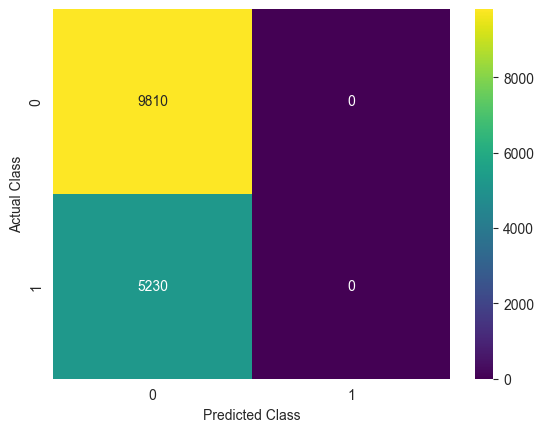

In [54]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.7147392742565535
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     39153
           1       0.74      0.28      0.41     21006

    accuracy                           0.71     60159
   macro avg       0.73      0.61      0.61     60159
weighted avg       0.72      0.71      0.67     60159

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7103058510638298
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      9810
           1       0.72      0.28      0.40      5230

    accuracy                           0.71     15040
   macro avg       0.71      0.61      0.60     15040
weighted avg       0.71      0.71      0.67     15040



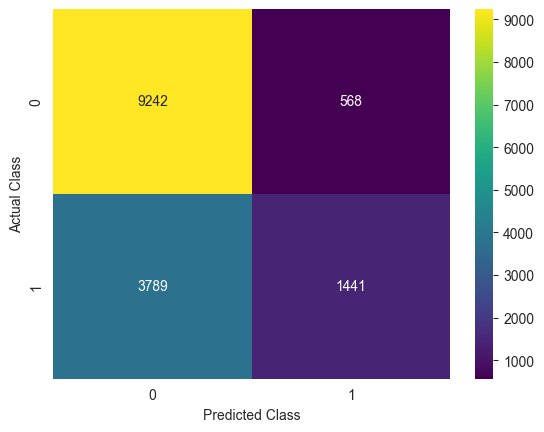

In [55]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.8513439385628085
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     39153
           1       0.97      0.59      0.74     21006

    accuracy                           0.85     60159
   macro avg       0.90      0.79      0.82     60159
weighted avg       0.87      0.85      0.84     60159

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.705718085106383
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      9810
           1       0.70      0.27      0.39      5230

    accuracy                           0.71     15040
   macro avg       0.70      0.60      0.60     15040
weighted avg       0.70      0.71      0.66     15040



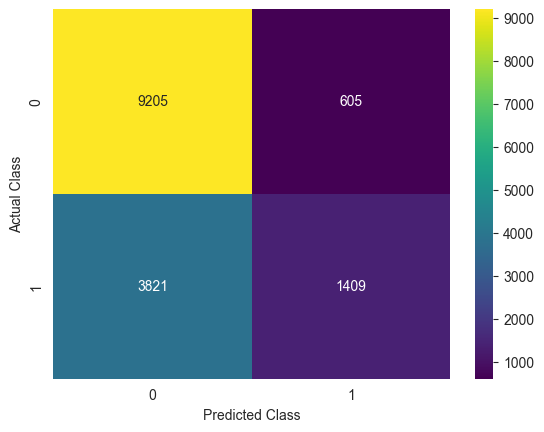

In [56]:
model = RandomForestClassifier(n_estimators=100,max_depth=15,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [58]:
print("finished")

finished
